# Задача классификации

Бизнес-задача: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

Основная цель проекта: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

#### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

In [82]:
#def rmse(y_true, y_pred):
    #return metrics.mean_squared_error(y_true, y_pred, squared = False)

#### Первичная обработка данных

In [3]:
# Прочитаем датасет
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [84]:
# Смотрим количество пропусков по столбцам
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [4]:
# Изучим содержимое столбца balance
df['balance'].head(10)

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
5           0  $ 
6       830,00 $ 
7       545,00 $ 
8         1,00 $ 
9             NaN
Name: balance, dtype: object

In [5]:
# Создадим функцию для преобразования содержимого столбца balance в число типа float
def to_float(x):
    x = str(x)
    x = x.replace(' ', '').replace(',00', '').replace('$', '')
    return x

In [6]:
# Преобразуем столбец
df['balance'] = df['balance'].apply(to_float).astype('float')

In [7]:
# Заменом пропуски на медианное значение по столбцу
df = df.fillna({'balance':df['balance'].median()})

In [8]:
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [9]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [10]:
# Изучим категориальные признаки на предмет пропущенных данных
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [95]:
df['education'].value_counts()

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [11]:
# Заменим попуски модальными значениями
df['job'] = df['job'].apply(lambda x: 'management' if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: 'secondary' if x == 'unknown' else x)

In [12]:
# Создадим функцию для выявения выбросов в признаках по межквартильному методу
def outliers_iqr(data, feature):
    x = data[feature]
    quart1, quart3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quart3-quart1
    low_bound = quart1-(iqr*1.5)
    up_bound = quart3+(iqr*1.5)
    print(f'low bound: {low_bound}, up bound: {up_bound}')
    outliers = data[(x<low_bound)|(x>up_bound)]
    cleaned = data[(x>=low_bound)&(x<=up_bound)]
    return outliers, cleaned

In [13]:
# Очистим датасет от выбросов по признаку balance
outliers, cleaned = outliers_iqr(df, 'balance')

low bound: -2241.0, up bound: 4063.0


### Разведывательный анализ

In [14]:
# Посмотрим соотношение классов целевой переменной
cleaned['deposit'].value_counts(normalize=True)

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

Text(0, 0.5, 'Количество')

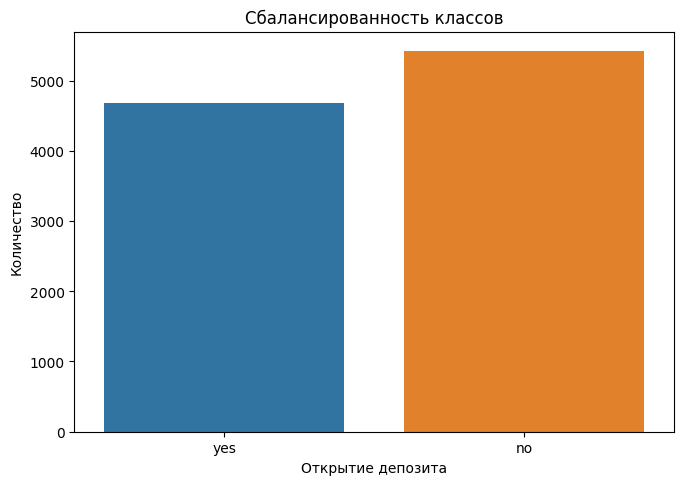

In [22]:
# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
sns.countplot(cleaned, x='deposit', ax=ax)
ax.set_title('Сбалансированность классов')
ax.set_xlabel('Открытие депозита')
ax.set_ylabel('Количество')

Явного дисбаланса не наблюдается

Рассчитаем описательные статистики для числовых и категориальных признаков

In [31]:
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [34]:
cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Визуализируем связи между признаками

1. Успешность маркетинговой кампании (открытие депозита) по месяцам

Text(0, 0.5, 'Количество')

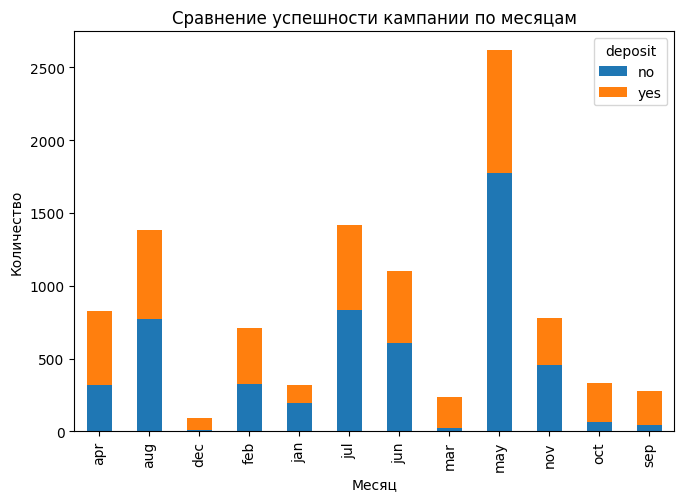

In [21]:
# Группируем данные по признаку месяца с количественным соотношением по таргету
types = cleaned.groupby("month")['deposit'].value_counts(normalize=False).unstack()

# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
types.plot(kind='bar', stacked='True', ax=ax)
ax.set_title('Сравнение успешности кампании по месяцам')
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество')


Мы видим, что результаты по месяцам достаточно сильно отличаются. Месяца с наибольшим количеством клиентов, вовлеченных в маркетинговую кампанию, отличаются большим числом отказов. С другой стороны, в декабре, марте, октябре и сентябре наблюдается значительный перевес в пользу ооткрытия депозита. Это может стать важным диагностическим признаком.

2. Зависимость таргета от возраста клиента

Text(0, 0.5, 'Количество')

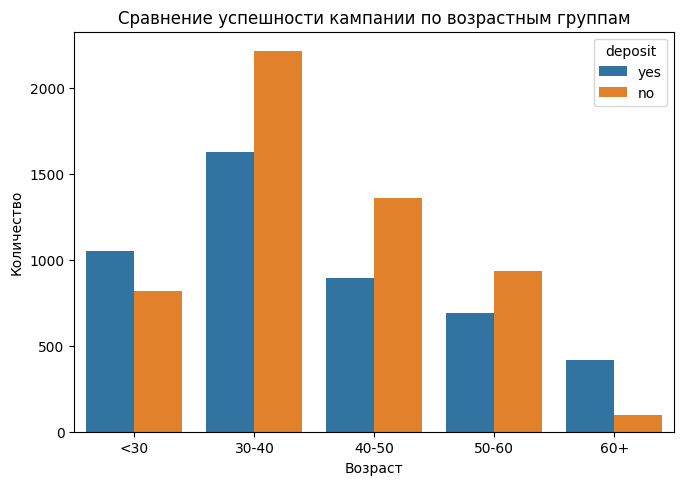

In [24]:
# Создадим признак возрастной группы
cleaned['age_group'] = pd.cut(df.age, [0,30,40,50,60,99], labels = ['<30','30-40','40-50','50-60','60+'])

# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
sns.countplot(x="age_group", hue="deposit", data=cleaned, ax=ax)
ax.set_title('Сравнение успешности кампании по возрастным группам')
ax.set_xlabel('Возраст')
ax.set_ylabel('Количество')

График показывает, что чаще всего по результатам маркетинговой кампании более склонны к открытию депозита клиенты 30-40 лет. В возрастных группах от 30 до 60 лет превалирует отрицательный результат, тогда как в группах до 30 и старше 60 лет клиенты чаще открывают депозит. Это так же указывает на связь возрастного и целевого признаков.

3. Зависимость целевого признака от семейного статуса

Text(0, 0.5, 'Семейный статус')

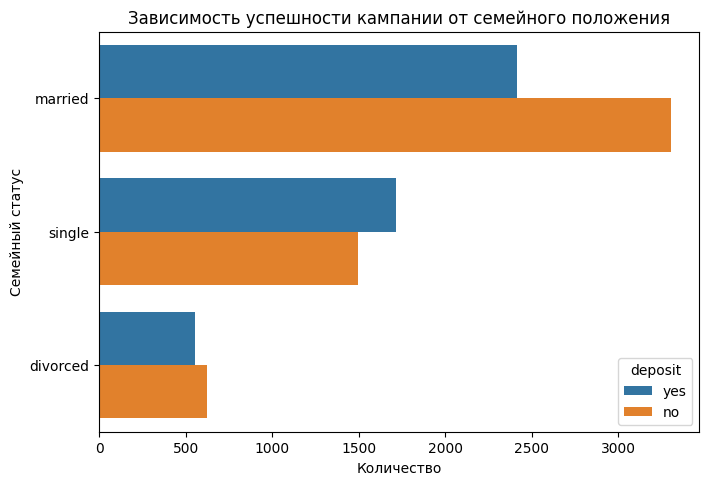

In [25]:
# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
sns.countplot(y='marital', hue='deposit', data=cleaned, ax=ax)
ax.set_title('Зависимость успешности кампании от семейного положения')
ax.set_xlabel('Количество')
ax.set_ylabel('Семейный статус')

Как видно из графика, семейное положение также влияет на вероятность успеха маркетинговой кампании. По отношению к общему числу открытых депозитов, большая часть принадлежит женатым людям. В то же время, если человек не в паре, он с большей вероятностью (пусть и незначительно) откроет счет.

4. Зависимость целевого признака от образования клиента

Text(0, 0.5, 'Уровень образования')

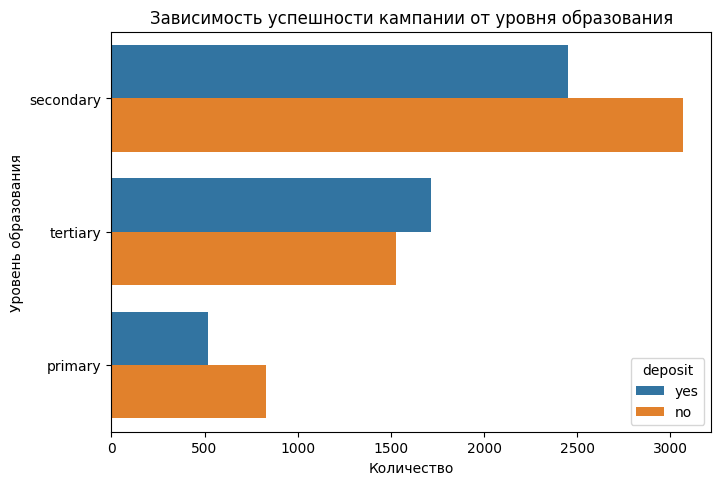

In [26]:
# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
sns.countplot(y='education', hue='deposit', data=cleaned, ax=ax)
ax.set_title('Зависимость успешности кампании от уровня образования')
ax.set_xlabel('Количество')
ax.set_ylabel('Уровень образования')

Здесь мы видим, что клиенты с начальным и средним образованием менее склонны к открытию депозита, чем люди с высшим образованием. Уровень образования тоже может пополнить ряд признаков, оказывающих прямое влияние на таргет.

5. Влияние профессиональной деятельности клиентов на целевой признак

Text(0, 0.5, 'Вид профессиональной деятельности')

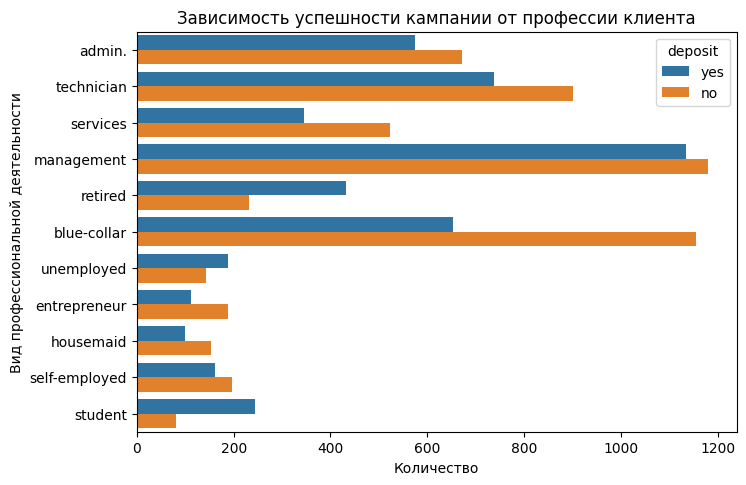

In [27]:
# Строим график
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes((1,1,1,1))
sns.countplot(y='job', hue='deposit', data=cleaned, ax=ax)
ax.set_title('Зависимость успешности кампании от профессии клиента')
ax.set_xlabel('Количество')
ax.set_ylabel('Вид профессиональной деятельности')

Данный график показывает различное распределение таргета по профессиям. Это говорит о том, что вероятность открытия депозита клиентом отчасти зависит и от рода его деятельности. В своих группах наиболее склонны к открытию депозита студенты, пенсионеры и безработные, как это ни странно.
Но от общего количества открытых счетов в результате маркетинговой кампании их, конечно же, не так много.

### Преобразование данных

### Задание 1

In [52]:
# преобразуйте уровни образования
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
cleaned['education'] = lab_enc.fit_transform(cleaned['education'])
cleaned['education'].sum()

11995

In [53]:
cleaned['age_group'] = lab_enc.fit_transform(cleaned['age_group'])
cleaned['age_group'].sum()

14524

In [54]:
cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


### Задания 2 и 3

In [55]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 1 if x=='yes' else 0)
cleaned['housing'] = cleaned['housing'].apply(lambda x: 1 if x=='yes' else 0)
cleaned['default'] = cleaned['default'].apply(lambda x: 1 if x=='yes' else 0)
cleaned['loan'] = cleaned['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [56]:
round((cleaned['default'].mean()+cleaned['housing'].mean()+cleaned['loan'].mean()),3)

0.635

In [57]:
cleaned.describe()


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,age_group
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,1.187036,0.016428,807.653538,0.481148,0.137853,15.590302,368.742603,2.517170,51.319644,0.816230,0.463236,1.437308
std,11.734931,0.647373,0.127119,994.151966,0.499669,0.344762,8.441510,346.651524,2.707159,109.644179,2.243795,0.498671,1.489490
min,18.000000,0.000000,0.000000,-2049.000000,0.000000,0.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,32.000000,1.000000,0.000000,95.000000,0.000000,0.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
50%,38.000000,1.000000,0.000000,445.000000,0.000000,0.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,0.000000,1.000000
75%,48.000000,2.000000,0.000000,1227.000000,1.000000,0.000000,22.000000,490.000000,3.000000,2.000000,1.000000,1.000000,2.000000
max,95.000000,2.000000,1.000000,4063.000000,1.000000,1.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,1.000000,4.000000


In [58]:
cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


### Задание 4

In [59]:
# создайте дамми-переменные
data = pd.get_dummies(cleaned, columns=['job','marital','contact','month','poutcome'])
data

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,39,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,32,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,43,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

In [61]:
import plotly.express as px

px.imshow(data.corr(),  height=1200, width=1200)

### Задания 7 и 8

In [62]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [63]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 45)

In [64]:
y_test.mean()

0.46326836581709147

### Задание 9

In [65]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

In [66]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

### Задание 10

In [67]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_sel)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train_sel)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test_sel)      # fransform() на test данных

print(X_test_scaled[:, 0].mean())  # для признака balance, обратите внимание именно на столбец

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [68]:

log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, log_reg.predict(X_test_scaled)))
# обучите логистическую регрессию и рассчитайте метрики качества

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [69]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, dt.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [70]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)
print(model_cv.best_params_)
print(model_cv.best_estimator_)
print(model_cv.best_score_)

{'max_depth': 7, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=7)
0.7959385297993128


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [71]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
print(metrics.classification_report(y_test, rf.predict(X_test_scaled)))
print(metrics.recall_score(y_test, rf.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

0.8330097087378641


### Задания 2 и 3

In [72]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

print(metrics.classification_report(y_test, gb.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [73]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=

In [74]:
y_pred = stack.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

0.8099547511312217


### Задание 5

In [75]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [76]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

In [77]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [78]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-11-20 12:57:17,474] A new study created in memory with name: RandomForestClassifier
[I 2023-11-20 12:57:18,938] Trial 0 finished with value: 0.8530331457160727 and parameters: {'n_estimators': 123, 'max_depth': 19, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8530331457160727.
[I 2023-11-20 12:57:21,200] Trial 1 finished with value: 0.9088909833490418 and parameters: {'n_estimators': 180, 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9088909833490418.
[I 2023-11-20 12:57:22,171] Trial 2 finished with value: 0.8454159459034439 and parameters: {'n_estimators': 120, 'max_depth': 22, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.9088909833490418.
[I 2023-11-20 12:57:23,665] Trial 3 finished with value: 0.8623595505617978 and parameters: {'n_estimators': 160, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9088909833490418.
[I 2023-11-20 12:57:25,497] Trial 4 finished with value: 0.8926059090198531 and parameters: {'n

CPU times: total: 36.8 s
Wall time: 38.8 s


In [79]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 187, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.93


In [80]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


In [81]:
print(metrics.accuracy_score(y_test, y_test_pred))

0.8257871064467767
